In [1]:
## set up the python2 with jupyter notebook

# 1. python2 -m pip install ipykernel
# 2. python2 -m ipykernel install --user

# some errors when configuring 
# a. "setuptools must be installed to install from a source distribution"
# solution: sudo pip install -U setuptools
# b. "Permission denied: '/usr/local/bin/......'"
# solution: sudo chown -R $(whoami) /usr/local

In [3]:
%matplotlib inline
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import requests
import sklearn
from sklearn.cluster import KMeans
from pyspark.mllib.clustering import KMeans, KMeansModel
requests.packages.urllib3.disable_warnings()
spark = pyspark.sql.SparkSession \
    .builder \
    .appName("Read Some Parquet") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

ValueError: Couldn't find Spark, make sure SPARK_HOME env is set or Spark is in an expected location (e.g. from homebrew installation).

# agg/profile exploration

In [5]:
agg_profile_all = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/agg/profileAgg")
aggprofile1 = spark.read.parquet('/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/agg/profileAgg/date=20170202')
aggprofile11 = spark.read.parquet('/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/agg/profileAgg/date=20161124/part-r-00001-1a1f1763-f48e-4612-9669-6752f5a3a3ee.snappy.parquet')


##  (1) Look into the columns/variables

In [45]:
agg_profile_all.take(2)

[Row(subscriberid=u'1000256437000000', privacy=u'OIN', osSet=[], vzCategMap={}, appCategMap={}, dmaMap={u'20170101': [u'743']}, stateMap={u'20170101': [u'AK']}, vzcategories=[], appcategories=[], dma=[u'743'], state=[u'AK'], date=20170202),
 Row(subscriberid=u'1001617822000000', privacy=u'NOO', osSet=[], vzCategMap={}, appCategMap={}, dmaMap={u'20170125': [u'756', u'533'], u'20170127': [u'575'], u'20170131': [u'533'], u'20170116': [u'533'], u'20170106': [u'567'], u'20161231': [u'533'], u'20161230': [u'575'], u'20170110': [u'575'], u'20170111': [u'533'], u'20170129': [u'533', u'567'], u'20170105': [u'533']}, stateMap={u'20170125': [u'MT', u'CT'], u'20170127': [u'TN'], u'20170131': [u'CT'], u'20170116': [u'CT'], u'20170106': [u'NC'], u'20161231': [u'CT'], u'20161230': [u'TN'], u'20170110': [u'TN'], u'20170111': [u'CT'], u'20170129': [u'CT', u'NC'], u'20170105': [u'CT']}, vzcategories=[], appcategories=[], dma=[u'533', u'575', u'756', u'567'], state=[u'CT', u'TN', u'MT', u'NC'], date=2017

In [20]:
aggprofile1.columns

['subscriberid',
 'privacy',
 'osSet',
 'vzCategMap',
 'appCategMap',
 'dmaMap',
 'stateMap',
 'vzcategories',
 'appcategories',
 'dma',
 'state']

## (2) Count the Rows:

In [21]:
aggprofrow =agg_profile_all.count()

In [18]:
print "agg/profile rows:", aggprofrow
print "agg/profiel columns:", len(agg_profile_all.columns)

agg/profile rows: 70995527
agg/profiel columns: 12


## (3) Count distinct values in each column

In [30]:
agg_profile_all.select('privacy').distinct().count(), agg_profile_all.select('osSet').distinct().count(), agg_profile_all.select('vzcategories').distinct().count(), agg_profile_all.select('appcategories').distinct().count(), agg_profile_all.select('dma').distinct().count(), agg_profile_all.select('state').distinct().count()

(3, 17, 597, 2, 237848, 130161)

In [ ]:
# agg_profile_all.dmaMap.map(lambda x: x[1])

## (4) Group the vzcategories

In [1]:
aggprofile1.filter(aggprofile1.vzcategories  = '[News and Magazines]')

SyntaxError: keyword can't be an expression (<ipython-input-1-f2244eba2ef2>, line 1)

In [8]:
aggprofile1.select("vzcategories").groupBy('vzcategories').count().orderBy('count', ascending=False).show()

+--------------------+------+
|        vzcategories| count|
+--------------------+------+
|                  []|973054|
|[News and Magazines]|  5283|
|            [Retail]|  3503|
|            [Sports]|  1855|
|        [Technology]|  1240|
|              [Food]|   976|
|        [Automotive]|   905|
|              [Home]|   868|
|           [Finance]|   862|
|[Health and Medic...|   828|
|            [Travel]|   693|
|      [Home, Retail]|   660|
|             [Music]|   660|
|    [Retail, Sports]|   599|
|     [Entertainment]|   465|
|      [Food, Retail]|   409|
| [Social Networking]|   378|
|           [Science]|   336|
|[Automotive, Retail]|   336|
|    [Kids and Teens]|   327|
+--------------------+------+
only showing top 20 rows



## (5) See the record of one user ID

In [41]:
aggprof_sampleid = agg_profile_all.filter("subscriberid ='1001617822000000'")

In [43]:
aggprof_sampleid.show(71)

+----------------+-------+-----+----------+-----------+--------------------+--------------------+------------+-------------+--------------------+----------------+--------+
|    subscriberid|privacy|osSet|vzCategMap|appCategMap|              dmaMap|            stateMap|vzcategories|appcategories|                 dma|           state|    date|
+----------------+-------+-----+----------+-----------+--------------------+--------------------+------------+-------------+--------------------+----------------+--------+
|1001617822000000|    NOO|   []|     Map()|      Map()|Map(20170105 -> W...|Map(20170105 -> W...|          []|           []|[533, 575, 756, 567]|[CT, TN, MT, NC]|20170202|
|1001617822000000|    NOO|   []|     Map()|      Map()|Map(20170105 -> W...|Map(20170105 -> W...|          []|           []|[533, 575, 756, 567]|[CT, TN, MT, NC]|20170201|
|1001617822000000|    NOO|   []|     Map()|      Map()|Map(20170105 -> W...|Map(20170105 -> W...|          []|           []|[533, 575, 756, 

In [44]:
aggprof_sampleid.take(1)

[Row(subscriberid=u'1001617822000000', privacy=u'NOO', osSet=[], vzCategMap={}, appCategMap={}, dmaMap={u'20170125': [u'756', u'533'], u'20170127': [u'575'], u'20170131': [u'533'], u'20170116': [u'533'], u'20170106': [u'567'], u'20161231': [u'533'], u'20161230': [u'575'], u'20170110': [u'575'], u'20170111': [u'533'], u'20170129': [u'533', u'567'], u'20170105': [u'533']}, stateMap={u'20170125': [u'MT', u'CT'], u'20170127': [u'TN'], u'20170131': [u'CT'], u'20170116': [u'CT'], u'20170106': [u'NC'], u'20161231': [u'CT'], u'20161230': [u'TN'], u'20170110': [u'TN'], u'20170111': [u'CT'], u'20170129': [u'CT', u'NC'], u'20170105': [u'CT']}, vzcategories=[], appcategories=[], dma=[u'533', u'575', u'756', u'567'], state=[u'CT', u'TN', u'MT', u'NC'], date=20170202)]

In [79]:
agg_profile_all.select("appcategories").groupBy('appcategories').count().orderBy('count', ascending=False).show()

+-------------+--------+
|appcategories|   count|
+-------------+--------+
|           []|70889380|
|           []|  106147|
+-------------+--------+



## Questions:  
what's in "vzCategMap", "appCategMap", "dmaMap", "stateMap"? \n
what are the vzcategories, appcategories, dma, state? Are they the same for each date-folder?


# agg/hist exploration

In [2]:
agg_hist_all = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/agg/hist")

In [3]:
agghist11 = spark.read.parquet('/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/agg/hist/date=20170202/part-r-00100-e5046983-1de1-4068-a5f3-50e9f899753b.snappy.parquet')


## (1) Check the columns

In [8]:
agghist11.columns

['subscriberid',
 'privacy',
 'osSet',
 'vzCategMap',
 'appCategMap',
 'dmaMap',
 'stateMap',
 'vzcategories',
 'appcategories',
 'dma',
 'state',
 'tldAggScores',
 'entityAggScores',
 'zipAggScores',
 'dynaGeoAggScores',
 'appNameAggScores',
 'tld',
 'entity',
 'zip',
 'dynaGeohash',
 'appname',
 'CLM',
 'age',
 'income',
 'homeowner_status_desc',
 'marital_status_cd',
 'gender',
 'education',
 'race_desc',
 'lang_desc',
 'child_in_hshld_flag',
 'zip5_cd',
 'acct_type',
 'acct_type_primary',
 'birth_year',
 'birth_month',
 'experian_match',
 'home_value',
 'residence',
 'occupation',
 'interest_automotive',
 'interest_travel',
 'interest_fitness',
 'interest_home_decor',
 'interest_outdoors',
 'interest_sports',
 'interest_sports_propensity',
 'contributes_to_charities',
 'contrib_to_charity_propensity',
 'purchased_via_mail',
 'purchased_via_mail_propensity',
 'purchase_via_online',
 'purchase_via_online_propensity',
 'internet_online_subscriber',
 'child_in_hshld_count',
 'mosaic_z4

In [9]:
agg_hist_all.take(1)

[Row(subscriberid=u'1000256437000000', privacy=u'OIN', osSet=[], vzCategMap={}, appCategMap={}, dmaMap={u'20170101': [u'743']}, stateMap={u'20170101': [u'AK']}, vzcategories=[], appcategories=[], dma=[u'743'], state=[u'AK'], tldAggScores=None, entityAggScores=None, zipAggScores={u'99502': 2.0}, dynaGeoAggScores={u'bdvk9': 2.0}, appNameAggScores=None, tld=None, entity=None, zip=[u'99502'], dynaGeohash=[u'bdvk9'], appname=None, CLM=None, age=None, income=None, homeowner_status_desc=None, marital_status_cd=None, gender=None, education=None, race_desc=None, lang_desc=None, child_in_hshld_flag=None, zip5_cd=None, acct_type=None, acct_type_primary=None, birth_year=None, birth_month=None, experian_match=None, home_value=None, residence=None, occupation=None, interest_automotive=None, interest_travel=None, interest_fitness=None, interest_home_decor=None, interest_outdoors=None, interest_sports=None, interest_sports_propensity=None, contributes_to_charities=None, contrib_to_charity_propensity=N

## (2) Count the rows

In [51]:
agghistrows =agg_hist_all.count()

In [54]:
print "agg/hist rows:", agghistrows
print "agg/hist columns:", len(agghist11.columns)

agg/hist rows: 999937
agg/hist columns: 73


## (3) See record for one user ID

In [55]:
agghist_sampleid = agg_hist_all.filter("subscriberid ='1001617822000000'")

In [56]:
agghist_sampleid.show()

+----------------+-------+-----+----------+-----------+--------------------+--------------------+------------+-------------+--------------------+----------------+------------+---------------+--------------------+--------------------+----------------+----+------+--------------------+--------------------+-------+----+----+------+---------------------+-----------------+------+---------+---------+---------+-------------------+-------+---------+-----------------+----------+-----------+--------------+----------+---------+----------+-------------------+---------------+----------------+-------------------+-----------------+---------------+--------------------------+------------------------+-----------------------------+------------------+-----------------------------+-------------------+------------------------------+--------------------------+--------------------+---------+----+---------+-----------------------+----------------------+----------------------+----------------------+-------------

In [57]:
agghist_sampleid.take(1)

[Row(subscriberid=u'1001617822000000', privacy=u'NOO', osSet=[], vzCategMap={}, appCategMap={}, dmaMap={u'20170125': [u'756', u'533'], u'20170127': [u'575'], u'20170131': [u'533'], u'20170116': [u'533'], u'20170106': [u'567'], u'20161231': [u'533'], u'20161230': [u'575'], u'20170110': [u'575'], u'20170111': [u'533'], u'20170129': [u'533', u'567'], u'20170105': [u'533']}, stateMap={u'20170125': [u'MT', u'CT'], u'20170127': [u'TN'], u'20170131': [u'CT'], u'20170116': [u'CT'], u'20170106': [u'NC'], u'20161231': [u'CT'], u'20161230': [u'TN'], u'20170110': [u'TN'], u'20170111': [u'CT'], u'20170129': [u'CT', u'NC'], u'20170105': [u'CT']}, vzcategories=[], appcategories=[], dma=[u'533', u'575', u'756', u'567'], state=[u'CT', u'TN', u'MT', u'NC'], tldAggScores=None, entityAggScores=None, zipAggScores={u'28722': 2.0, u'59068': 1.0, u'37301': 8.0, u'06037': 16.0, u'71107': 1.0}, dynaGeoAggScores={u'c840': 1.0, u'dnm88u': 2.0, u'9vv1': 1.0, u'dn71': 8.0, u'drkk81': 16.0}, appNameAggScores=None, t

## (4) Check the "tldAggScores" - without the none-values

In [64]:
agg_hist_all.select('tldAggScores').take(20)

[Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores={u'glenbrookdodgechryslerjeep.com': 1.0}),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores={u'roger-russell.com': 1.0, u'baldtruthtalk.com': 1.0, u'usmilitarymuseum.org': 1.0, u'parkweb.vic.gov.au': 1.0}),
 Row(tldAggScores={u'lindasecrist.com': 1.0}),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores=None),
 Row(tldAggScores={u'bcferries.com': 1.0}),
 Row(tldAggScores={u'golfcollege.edu': 1.0}),
 Row(tldAggScores={u'elcoyotecafe.com': 1.0, u'cccti.edu': 1.0}),
 Row(tldAggScores={u'propertyresourcesgroup.com': 1.0, u'bryancountyga.org': 1.0})]

In [73]:
agg_hist_all.select('tldAggScores').na.drop().count()

330148

In [75]:
agg_hist_all.select('tldAggScores').na.drop().take(20)

[Row(tldAggScores={u'glenbrookdodgechryslerjeep.com': 1.0}),
 Row(tldAggScores={u'roger-russell.com': 1.0, u'baldtruthtalk.com': 1.0, u'usmilitarymuseum.org': 1.0, u'parkweb.vic.gov.au': 1.0}),
 Row(tldAggScores={u'lindasecrist.com': 1.0}),
 Row(tldAggScores={u'bcferries.com': 1.0}),
 Row(tldAggScores={u'golfcollege.edu': 1.0}),
 Row(tldAggScores={u'elcoyotecafe.com': 1.0, u'cccti.edu': 1.0}),
 Row(tldAggScores={u'propertyresourcesgroup.com': 1.0, u'bryancountyga.org': 1.0}),
 Row(tldAggScores={u'smscsoccer.com': 1.0, u'texaspepperjelly.com': 1.0, u'maryannmc.com': 1.0, u'kfc.com.cn': 1.0}),
 Row(tldAggScores={u'pirelli.com': 1.0, u'ossipeelakere.com': 1.0, u'rlac.com': 1.0, u'copt.com': 1.0, u'mayersonjcc.org': 1.0}),
 Row(tldAggScores={u'chevytalk.org': 1.0, u'barnesville.k12.oh.us': 1.0}),
 Row(tldAggScores={u'ocean.k12.wa.us': 1.0}),
 Row(tldAggScores={u'townofkentct.org': 1.0, u'windhamhouse.com': 1.0, u'ultimateinsurancejobs.com': 1.0, u'patrickjames.com': 1.0, u'westfieldnj.com'

In [6]:
tldscore = agg_hist_all.select('tldAggScores').na.drop().toPandas()

In [ ]:
agg_hist_all.select('tldAggScores').na.drop().

In [7]:
a = np.zeros((330148,1))
for i in range(a.shape[0]):
    a[i] =len(tldscore['tldAggScores'][i])
np.amax(a)

15.0

## (5) Count the occurance of each website

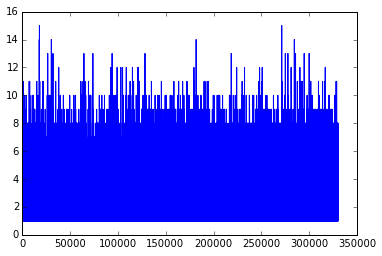

In [7]:
plt.plot(a)
plt.show()

In [ ]:
#tldscore['tldAggScores'].value_counts()

In [9]:
import ast
#tldscore["tldAggScores"] =  tldscore["tldAggScores"].map(lambda d : ast.literal_eval(d))

## (6) More exploration on tldAggScores

In [25]:
agg_hist_all.select(explode(agg_hist_all.tldAggScores).alias("key", "value")).show()

+--------------------+-----+
|                 key|value|
+--------------------+-----+
|glenbrookdodgechr...|  1.0|
|usmilitarymuseum.org|  1.0|
|   baldtruthtalk.com|  1.0|
|   roger-russell.com|  1.0|
|  parkweb.vic.gov.au|  1.0|
|    lindasecrist.com|  1.0|
|       bcferries.com|  1.0|
|     golfcollege.edu|  1.0|
|           cccti.edu|  1.0|
|    elcoyotecafe.com|  1.0|
|   bryancountyga.org|  1.0|
|propertyresources...|  1.0|
|          kfc.com.cn|  1.0|
|      smscsoccer.com|  1.0|
|texaspepperjelly.com|  1.0|
|       maryannmc.com|  1.0|
|            rlac.com|  1.0|
|     mayersonjcc.org|  1.0|
|   ossipeelakere.com|  1.0|
|            copt.com|  1.0|
+--------------------+-----+
only showing top 20 rows



In [22]:
agg_hist_all.select(explode(agg_hist_all.tldAggScores).alias("key", "value")).groupBy("key").count().orderBy("count",ascending=False).show(100)

+--------------------+-----+
|                 key|count|
+--------------------+-----+
|curryhealthnetwor...|   15|
|shopoldcoloradoci...|   14|
|     signaturehd.com|   14|
|     grasshopper.com|   14|
|         bethelu.edu|   13|
|        oilprice.com|   13|
|            n4bb.com|   13|
|   halcolighting.com|   13|
|          nonnis.com|   13|
|     healthlinks.net|   13|
|          scopes.com|   13|
|thenews-democrat.com|   12|
|ultrasonacolumbus...|   12|
|      mtu-online.com|   12|
|frederickcosmetic...|   12|
|jagermeistersheph...|   12|
|    burnshyundai.com|   12|
|        rentalia.com|   12|
|broadwayinchicago...|   12|
|      squawcreek.com|   12|
|         ziebart.com|   12|
|   watsonquality.com|   12|
|     ameshistory.org|   12|
|   languagestars.com|   12|
|     billionauto.com|   12|
|    firenzegifts.com|   12|
|        marworth.org|   12|
|      keptelenseg.hu|   12|
|     fnbgranbury.com|   12|
|  stbarnabashigh.com|   12|
|       google.com.br|   12|
|         coll

In [29]:
tldcount = agg_hist_all.select(explode(agg_hist_all.tldAggScores).alias("key", "value")).groupBy("key").count().orderBy("count",ascending=False).toPandas()

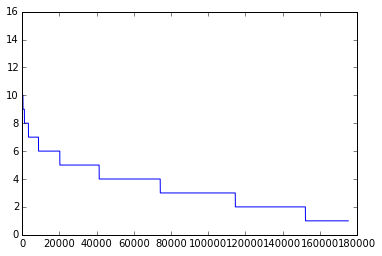

In [31]:
plt.plot(tldcount['count'])

In [24]:
agg_hist_all.select(explode(agg_hist_all.tldAggScores).alias("key", "value")).groupBy("key").count().orderBy("key",ascending=True).show(100)

+--------------------+-----+
|                 key|count|
+--------------------+-----+
|             007.com|    2|
|        00server.com|    5|
|           01net.com|    3|
|              048.ua|    4|
|  0800-horoscope.com|    2|
|  1-800-balloons.com|    1|
|  1-800-dryclean.com|    3|
|1-800-shaved-ice.com|    2|
| 1-800homeopathy.com|    3|
|   1-877-spirits.com|    5|
|    1-87vehicles.org|    2|
| 1-computerdesks.com|    3|
|  1-save-on-lens.com|    3|
|     10-2-4ranch.com|    3|
|           10-75.net|    3|
| 10-minute-plays.com|    5|
|            10-s.com|    2|
|      10000birds.com|    1|
|       1000acres.com|    5|
|1000aircraftphoto...|    4|
|       1000bulbs.com|    3|
|1000islands-clayt...|    2|
|       1000miglia.eu|    3|
|  1000oaksbarrel.com|    2|
|  1000peacewomen.org|    4|
|1000thingstoronto...|    2|
|  1000uglypeople.com|    6|
|  1001beersteins.com|    5|
|   1001cocktails.com|    4|
|     1001goroskop.ru|    6|
|     1001recepti.com|    1|
|   1005freshr

In [70]:
agghist = agg_hist_all.select('subscriberid','tldAggScores','vzcategories','dma').na.drop().toPandas()

In [5]:
agg_hist_all.select('subscriberid','tldAggScores','vzcategories','dma').na.drop().groupBy('dma').count().orderBy('count', ascending=False).show(100)

+----------+------+
|       dma| count|
+----------+------+
|        []|119622|
|     [743]| 45615|
|     [501]|  3267|
|     [803]|  1754|
|     [504]|  1533|
|     [506]|  1511|
|     [613]|  1417|
|     [602]|  1268|
|     [511]|  1248|
|     [623]|  1187|
|     [751]|  1096|
|     [508]|  1092|
|     [807]|   945|
|     [819]|   923|
|     [609]|   920|
|     [524]|   913|
|     [564]|   869|
|     [618]|   847|
|     [510]|   793|
|     [753]|   760|
|     [505]|   759|
|     [770]|   756|
|     [616]|   751|
|     [527]|   734|
|     [820]|   729|
|     [862]|   727|
|     [539]|   726|
|     [659]|   711|
|     [577]|   702|
|     [523]|   685|
|     [678]|   674|
|     [532]|   672|
|     [790]|   663|
|     [650]|   638|
|     [693]|   632|
|     [722]|   631|
|[743, 501]|   629|
|     [724]|   615|
|     [514]|   609|
|     [679]|   602|
|[501, 743]|   582|
|     [533]|   573|
|     [632]|   573|
|     [515]|   570|
|     [725]|   563|
|     [566]|   557|
|     [500]|   547|


In [4]:
agghist = agg_hist_all.select('subscriberid','tldAggScores').na.drop().toPandas()

In [11]:
agghist.head()

,subscriberid,tldAggScores
0,1002918146000000,{u'glenbrookdodgechryslerjeep.com': 1.0}
1,1012055392000000,"{u'roger-russell.com': 1.0, u'baldtruthtalk.co..."
2,1015120891000000,{u'lindasecrist.com': 1.0}
3,1018474139000000,{u'bcferries.com': 1.0}
4,1018968166000000,{u'golfcollege.edu': 1.0}


In [7]:
agghist_idtldscore= agg_hist_all.select('subscriberid','tldAggScores').na.drop()

In [13]:
agghist_idtldscore.select("subscriberid", explode(agg_hist_all.tldAggScores).alias("key", "value")).show(20)

+----------------+--------------------+-----+
|    subscriberid|                 key|value|
+----------------+--------------------+-----+
|1002918146000000|glenbrookdodgechr...|  1.0|
|1012055392000000|usmilitarymuseum.org|  1.0|
|1012055392000000|   baldtruthtalk.com|  1.0|
|1012055392000000|   roger-russell.com|  1.0|
|1012055392000000|  parkweb.vic.gov.au|  1.0|
|1015120891000000|    lindasecrist.com|  1.0|
|1018474139000000|       bcferries.com|  1.0|
|1018968166000000|     golfcollege.edu|  1.0|
|1018993199000000|           cccti.edu|  1.0|
|1018993199000000|    elcoyotecafe.com|  1.0|
|1019396984000000|   bryancountyga.org|  1.0|
|1019396984000000|propertyresources...|  1.0|
|1027589075000000|          kfc.com.cn|  1.0|
|1027589075000000|      smscsoccer.com|  1.0|
|1027589075000000|texaspepperjelly.com|  1.0|
|1027589075000000|       maryannmc.com|  1.0|
|1033106947000000|            rlac.com|  1.0|
|1033106947000000|     mayersonjcc.org|  1.0|
|1033106947000000|   ossipeelakere

In [92]:
agghist.rdd = agghist_idtldscore.select("subscriberid", explode(agg_hist_all.tldAggScores).alias("key", "value"))

In [8]:
agghist = agghist_idtldscore.select("subscriberid", explode(agg_hist_all.tldAggScores).alias("key", "value")).toPandas()

In [9]:
agghist

,subscriberid,key,value
0,1002918146000000,glenbrookdodgechryslerjeep.com,1.0
1,1012055392000000,usmilitarymuseum.org,1.0
2,1012055392000000,baldtruthtalk.com,1.0
3,1012055392000000,roger-russell.com,1.0
4,1012055392000000,parkweb.vic.gov.au,1.0
5,1015120891000000,lindasecrist.com,1.0
6,1018474139000000,bcferries.com,1.0
7,1018968166000000,golfcollege.edu,1.0
8,1018993199000000,cccti.edu,1.0
9,1018993199000000,elcoyotecafe.com,1.0


In [108]:
len(agghist['subscriberid'].unique()), len(agghist['key'].unique()),len(agghist['value'].unique())

(330148, 175325, 2)

In [110]:
agghist.groupby('value').sum()

,subscriberid,key
value,,
1.0,1002918146000000101205539200000010120553920000...,glenbrookdodgechryslerjeep.comusmilitarymuseum...
2.0,2894701244000000,lcmschools.org


In [10]:
rowsum = agghist.groupby('subscriberid').sum()


In [11]:
rowsum

,value
subscriberid,
1000003425000000,1.0
1000030914000000,2.0
1000036049000000,1.0
1000041030000000,1.0
1000044840000000,1.0
1000062252000000,1.0
1000068889000000,2.0
1000072174000000,2.0
1000092045000000,1.0


In [12]:
rowsum.sr = rowsum.sort_values(by='value', ascending = False)['value']

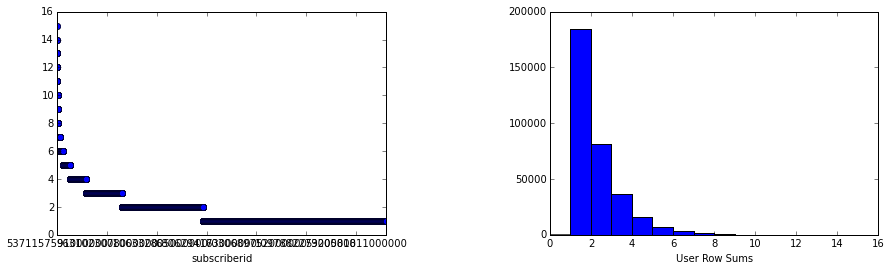

In [13]:
plt.figure(1)
plt.subplot(121)
rowsum.sr.plot(style="bo")
plt.savefig('rowsun.png')

plt.subplot(122)
bins = np.arange(0., 16., 1.)
plt.hist(rowsum.sr, bins)
plt.xlabel("User Row Sums")

plt.subplots_adjust(left=0.1, right=2, wspace=0.5, hspace=0.45)


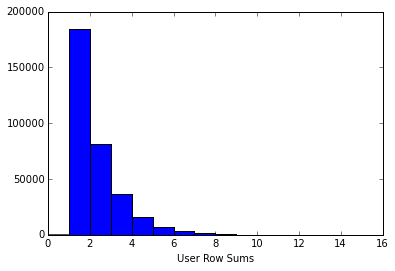

In [38]:
bins = np.arange(0., 16., 1.)
plt.hist(rowsum.sr, bins)
plt.xlabel("User Row Sums")
plt.savefig('rowsumhist.png')

In [14]:
colsum = agghist.groupby('key').sum()
colsum

,value
key,
007.com,2.0
00server.com,5.0
01net.com,3.0
048.ua,4.0
0800-horoscope.com,2.0
1-800-balloons.com,1.0
1-800-dryclean.com,3.0
1-800-shaved-ice.com,2.0
1-800homeopathy.com,3.0


In [15]:
colsum.sr =colsum.sort_values(by='value', ascending = False)['value']


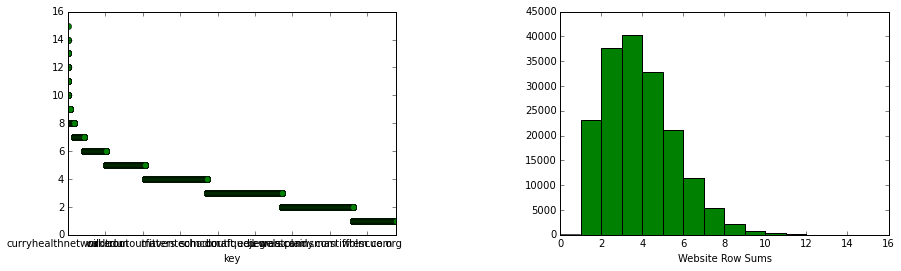

In [16]:
plt.figure(1)
plt.subplot(121)
colsum.sr.plot(style="go")

plt.subplot(122)
bins = np.arange(0., 16., 1.)
plt.hist(colsum.sr, bins,color='g')
plt.xlabel("Website Column Sums")

plt.subplots_adjust(left=0.1, right=2, wspace=0.5, hspace=0.45)
plt.savefig("colsum.png")

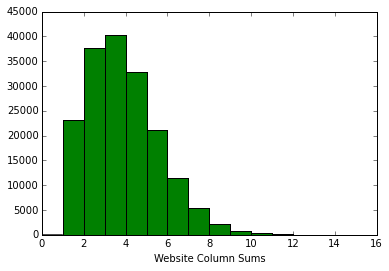

In [17]:
bins = np.arange(0., 16., 1.)
plt.hist(colsum.sr, bins,color='g')
plt.xlabel("Website Column Sums")
plt.savefig("colsumhist.png")

In [77]:
agghist.to_csv("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agghist.txt", index=False)

In [4]:
agghist_dma = agg_hist_all.select('subscriberid','tldAggScores','dma').na.drop()

In [5]:
#agghist_dma.createTempView("agghistdma")
agghist_dma.filter(agghist_dma.dma[0].like('%501%'))

DataFrame[subscriberid: string, tldAggScores: map<string,double>, dma: array<string>]

In [6]:
agghist_dma_pd= agghist_dma.filter(agghist_dma.dma[0].like('%501%')).select("subscriberid", explode(agg_hist_all.tldAggScores).alias("key", "value")).toPandas()

In [7]:
datadma = agghist_dma.filter(agghist_dma.dma[0].like('%501%')).select("tldAggScores").toPandas()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
def tokenize(text):
    return(text)
vectorizer = CountVectorizer(min_df=1,tokenizer=tokenize,lowercase=False)
data = datadma.values.ravel().tolist()
X = vectorizer.fit_transform(data)
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

In [33]:
dma501websites = map(lambda a: str(a), feature_names)
dma501websites

AttributeError: 'list' object has no attribute 'topandas'

In [55]:
import scipy.io
scipy.io.mmwrite('data_dma501',X)

In [37]:
with open("dma501_websites.txt", "w") as output:
    output.write("\n".join(dma501websites))

# oneday/profile exploration

In [27]:
oneday_profile_all = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/oneday/profile")
oneday_profile_1 = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/oneday/profile/date=20161124")
oneday_profile_11 = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/oneday/profile/date\=20161124/part-r-00000-597babaa-7df1-49db-8ef2-de01b07e103e.snappy.parquet")

## (1) Check the columns

In [32]:
oneday_profile_1.columns

['osSet',
 'vzCategMap',
 'appCategMap',
 'dmaMap',
 'stateMap',
 'subscriberid',
 'privacy']

## (2) check one particular ID. Different with agg/profile data

In [36]:
oneday_profile_all.filter("subscriberid ='1001617822000000'").take(1)

[Row(osSet=None, vzCategMap=None, appCategMap=None, dmaMap=None, stateMap=None, subscriberid=u'1001617822000000', privacy=u'NOO', date=20170121)]

# oneday/feature exploration

In [28]:
oneday_feature_all = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/oneday/feature")
oneday_feature_11 = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/oneday/feature/day\=2016-11-24/part-r-00200-14c90367-a1f3-4cc5-b409-18b65f735fb3.snappy.parquet")
oneday_feature_1 = spark.read.parquet("/Users/fengmei/SJSU_ClASSES/Math203/Verizon/Data/agg/oneday/feature/day\=2016-11-24")

## (1) Check the columns

In [33]:
oneday_feature_1.columns

['subscriberid', 'featureValue', 'featureType', 'measure']

## (2) Check the same ID

In [37]:
oneday_feature_all.filter("subscriberid ='1001617822000000'").show()

+----------------+------------+-----------+-------+----------+
|    subscriberid|featureValue|featureType|measure|       day|
+----------------+------------+-----------+-------+----------+
|1001617822000000|        c840|          4|    1.0|2017-01-25|
|1001617822000000|        dn71|          4|    1.0|2016-12-01|
|1001617822000000|      dnm88u|          4|    1.0|2017-01-06|
|1001617822000000|        dn71|          4|    1.0|2017-01-27|
|1001617822000000|        dn71|          4|    1.0|2016-12-30|
|1001617822000000|      drkk81|          4|    1.0|2017-01-31|
|1001617822000000|       06037|          3|    1.0|2017-01-25|
|1001617822000000|      drkk81|          4|    1.0|2017-01-05|
|1001617822000000|      drkk81|          4|    1.0|2016-12-03|
|1001617822000000|       06037|          3|    1.0|2017-01-29|
|1001617822000000|      drkk81|          4|    1.0|2017-01-29|
|1001617822000000|       37301|          3|    1.0|2016-12-01|
|1001617822000000|      drkk81|          4|    1.0|2016

## (3) FeatureValues counts

In [87]:
oneday_feature_all.select("featureValue").groupBy("featureValue").count().orderBy("count", ascending=False).show()

+------------+-------+
|featureValue|  count|
+------------+-------+
|       99502|2253747|
|       bdvk9|2252695|
|       bdvkd|  25316|
|  Apple Mail|   6790|
|       07094|   4248|
|       94044|   3631|
|       14072|   3267|
|       94965|   2864|
|       94801|   2774|
|       84116|   2526|
|       07470|   2387|
|       98110|   2335|
|       94941|   2158|
|       07047|   2150|
|       90265|   2145|
|       20016|   2082|
|        dntj|   1969|
|        dntx|   1939|
|        dnwn|   1892|
|       19063|   1875|
+------------+-------+
only showing top 20 rows



## (4) FeatureType counts

In [42]:
oneday_feature_all.select("featureType").groupBy("featureType").count().orderBy("count", ascending=False).show()

+-----------+-------+
|featureType|  count|
+-----------+-------+
|          4|8040083|
|          3|7361740|
|          1| 591637|
|          2| 208948|
|          5|   6790|
+-----------+-------+



## (5) It seems- type 1 == website, type2== ?, type3,4 == zip,Geohash, type 5 ==Apple Mail

In [43]:
oneday_feature_all.filter("featureType='1'").take(3)

[Row(subscriberid=u'6313291015000000', featureValue=u'providenceday.org', featureType=1, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'2938840425000000', featureValue=u'dryprosystems.com', featureType=1, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'3808120490000000', featureValue=u'testoil.com', featureType=1, measure=1.0, day=datetime.date(2016, 12, 25))]

In [47]:
oneday_feature_all.filter("featureType='5'").take(2)

[Row(subscriberid=u'1971430657000000', featureValue=u'Apple Mail', featureType=5, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'3752693529000000', featureValue=u'Apple Mail', featureType=5, measure=1.0, day=datetime.date(2016, 12, 30))]

In [91]:
oneday_feature_all.filter("featureType='2'").take(5)

[Row(subscriberid=u'4448036634000000', featureValue=u'tahitians', featureType=2, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'5013798988000000', featureValue=u'scyphate', featureType=2, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'6799595959000000', featureValue=u'pollack', featureType=2, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'6427197133000000', featureValue=u'oliguria', featureType=2, measure=1.0, day=datetime.date(2016, 12, 25)),
 Row(subscriberid=u'1000625301000000', featureValue=u'bumblebee', featureType=2, measure=1.0, day=datetime.date(2016, 12, 25))]

In [69]:
feature_ids = oneday_feature_all.select("subscriberid").dropDuplicates().count()

In [70]:
feature_ids

799317

In [62]:
oneday_feature_all.select("subscriberid").groupBy("subscriberid").count().orderBy("count", ascending=False).show()

+----------------+-----+
|    subscriberid|count|
+----------------+-----+
|5045815586000000|  494|
|6845556198000000|  469|
|2175509201000000|  429|
|2340023061000000|  408|
|3684964045000000|  388|
|4145651965000000|  353|
|9832897347000000|  314|
|6700529660000000|  312|
|1705189336000000|  292|
|5153246807000000|  292|
|4273239834000000|  292|
|1027861811000000|  290|
|4877757619000000|  289|
|2110761696000000|  283|
|9261402637000000|  282|
|7151434612000000|  277|
|8824215702000000|  275|
|5263873858000000|  274|
|1238791231000000|  274|
|5129652725000000|  269|
+----------------+-----+
only showing top 20 rows



In [68]:
# agg_hist_all.join(feature_ids, agg_hist_all.subscriberid == feature_ids.subscriberid, 'inner').drop(agg_hist_all.subscriberid).count()